# Applying the DDM to the Bayesian switching observer of Laquitaine & Gardner

Code:
- imports at the top of the collab
- write parameters as separate objects outside the function call (e.g., dt, dx ...) so that we know when it's changed between model fits


Model fitting:

*   add one component at a time
*   begin by less theory driven elements

https://www.frontiersin.org/articles/10.3389/fpsyg.2022.1039172/full

- to be discussed: also incorporate difference in direction between prior and motion direction (strength and direction could play a role here? --> create a single variable)
- fit a more complex model
- improvement during experiment --> see whether drift rate increases as experiment progresses?
- when running the model fitting part --> should loop over participants and fit model for each subject seperately. Then do group analysis

In [1]:
#@title Install PyDDM on Google Colab
!pip -q install git+https://github.com/mwshinn/PyDDM

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# @title Libraries

import numpy as np
from pyddm import Sample
import pyddm as ddm
import pyddm.plot
from pyddm import Model, Fittable
from pyddm import Drift
from pyddm.functions import fit_adjust_model, display_model
from pyddm.models import NoiseConstant, BoundConstant, OverlayChain, OverlayNonDecision, OverlayPoissonMixture
from pyddm.models.loss import LossBIC
from pyddm.plot import model_gui
from pyddm.models import BoundCollapsingExponential, BoundCollapsingLinear

from pyddm import Noise
from pyddm import Bound
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os, requests
from matplotlib import colors
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
from numpy import pi
from copy import copy
from scipy.stats import pearsonr, zscore


In [3]:
# @title Data retrieval

url = "https://github.com/steevelaquitaine/projInference/raw/gh-pages/data/csv/data01_direction4priors.csv"

try:
  RequestAPI = requests.get(url)
except requests.ConnectionError:
  print("Failed to download data. Please contact steeve.laquitaine@epfl.ch")
else:
  if RequestAPI.status_code != requests.codes.ok:
    print("Failed to download data. Please contact steeve.laquitaine@epfl.ch")
  else:
    with open("data01_direction4priors.csv", "wb") as fid:
      fid.write(RequestAPI.content)


In [4]:
# @title Data loading

data = pd.read_csv("data01_direction4priors.csv")
data.head()

,trial_index,trial_time,response_arrow_start_angle,motion_direction,motion_coherence,estimate_x,estimate_y,reaction_time,raw_response_time,prior_std,prior_mean,subject_id,experiment_name,experiment_id,session_id,run_id
0,1,0.000000,NaN,225,0.12,-1.749685,-1.785666,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
1,2,2.730730,NaN,225,0.12,-1.819693,-1.714269,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
2,3,4.913950,NaN,235,0.06,-1.562674,-1.951422,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
3,4,6.997296,NaN,225,0.06,-1.601388,-1.919781,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
4,5,9.097130,NaN,215,0.24,-1.639461,-1.887371,NaN,NaN,10,225,1,data01_direction4priors,11,1,1


In [5]:
# @title Useful functions

# circular statistics utils
# -------------------
def get_cartesian_to_deg(
    x: np.ndarray, y: np.ndarray, signed: bool
) -> np.ndarray:
    """convert cartesian coordinates to
    angles in degree
    Args:
        x (np.ndarray): x coordinate
        y (np.ndarray): y coordinate
        signed (boolean): True (signed) or False (unsigned)
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_cartesian_to_deg
            x = np.array([1, 0, -1, 0])
            y = np.array([0, 1, 0, -1])
            degree = get_cartesian_to_deg(x,y,False)
            # Out: array([  0.,  90., 180., 270.])
    Returns:
        np.ndarray: angles in degree
    """
    # convert to radian (ignoring divide by 0 warning)
    with np.errstate(divide="ignore"):
        degree = np.arctan(y / x)

    # convert to degree and adjust based
    # on quadrant
    for ix in range(len(x)):
        if (x[ix] >= 0) and (y[ix] >= 0):
            degree[ix] = degree[ix] * 180 / np.pi
        elif (x[ix] == 0) and (y[ix] == 0):
            degree[ix] = 0
        elif x[ix] < 0:
            degree[ix] = degree[ix] * 180 / np.pi + 180
        elif (x[ix] >= 0) and (y[ix] < 0):
            degree[ix] = degree[ix] * 180 / np.pi + 360

    # if needed, convert signed to unsigned
    if not signed:
        degree[degree < 0] = degree[degree < 0] + 360
    return degree

In [6]:
# @title Data preprocessing

# we convert cartesian estimates into a degree
data["estimate_deg"] = np.round(get_cartesian_to_deg(data["estimate_x"].values, data["estimate_y"].values, False))

# difference between prior and showed direction
data["prior_minus_current_t"] = abs(data["prior_mean"] - data["motion_direction"])


<ipython-input-7-c43e79bbc5ae>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rt["reaction_time"].fillna(data_rt["est_rt"], inplace=True)


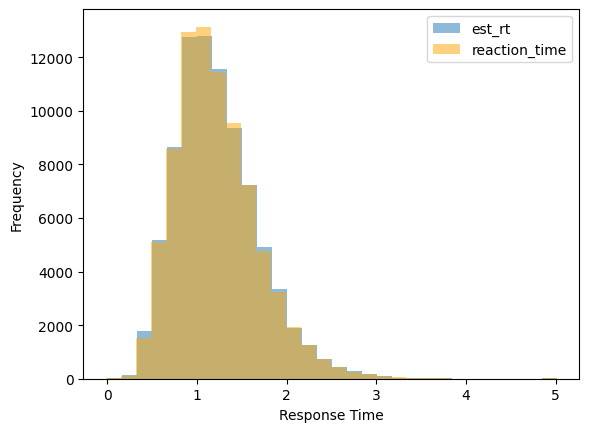

count    82824.000000
mean         1.235529
std          0.471504
min          0.000273
25%          0.905834
50%          1.171665
75%          1.500221
max          5.010876
Name: est_rt, dtype: float64
count    82824.000000
mean         1.222330
std          0.467946
min         -0.018289
25%          0.891687
50%          1.154560
75%          1.482013
max          5.010876
Name: reaction_time, dtype: float64


In [7]:
# @title Add estimated reaction times

# est_rt = trial_time(t+1)-trial_time(t)-1s(fixation)-0.3s(motion display)-0.1s(confirmation)-0.1s(feedback)

# Calculate the 'est_rt' by subtracting the current row's 'trial_time' from the next row's 'trial_time'
data['est_rt'] = data.groupby('run_id')['trial_time'].shift(-1) - data['trial_time'] - 1 - 0.3 - 0.1 - 0.1

# select est rt > 0
data_rt = data[data["est_rt"] >= 0]

# Replace NaN values in 'reaction_times' with 'est_rt' values
data_rt["reaction_time"].fillna(data_rt["est_rt"], inplace=True)

# subset not na values
data_rt = data_rt[data_rt["reaction_time"].notna()]

# Assuming 'data_rt' DataFrame contains 'est_rt' and 'reaction_time' columns
est_rt_values = data_rt['est_rt']
reaction_time_values = data_rt['reaction_time']

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Plot the histogram for 'est_rt'
ax.hist(est_rt_values, bins=30, alpha=0.5, label='est_rt')

# Plot the histogram for 'reaction_time' and set a different color
ax.hist(reaction_time_values, bins=30, alpha=0.5, label='reaction_time', color='orange')

# Set labels and legend
ax.set_xlabel('Response Time')
ax.set_ylabel('Frequency')
ax.legend()

# Show the plot
plt.show()

print(est_rt_values.describe())
print(reaction_time_values.describe())


0.13662569490483356 0.0


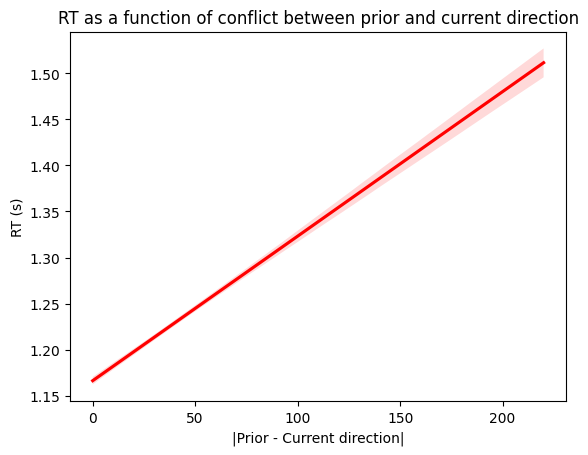

In [8]:
# Perform hypothesis test for Pearson correlation coefficient
correlation, p_value = pearsonr(data_rt['prior_minus_current_t'], data_rt['reaction_time'])
print(correlation, p_value)

#Regression line
sns.regplot(x='prior_minus_current_t', y='reaction_time', color='red', scatter = False,
                 scatter_kws={"color": "blue",
                              "alpha": 0.2},
            line_kws={"color": "red"}, ci=95, data=data_rt)

# Add labels and title
plt.xlabel('|Prior - Current direction|')
plt.ylabel('RT (s)')
plt.title('RT as a function of conflict between prior and current direction')

# Display the plot
plt.show()

In [9]:
# @title DDM data preprocessing

# create the midpoint between prior and showed direction
data_rt["midpoint"] = (data_rt["motion_direction"] + 225) / 2

#sanity check
data_rt["midpoint"].describe()

# we create a variable named choice used to categorize whether subject used on strategy or the other
# if midpoint --> used prior (strategy 0)
conds = [
    (data_rt['midpoint'] > 225) & (data_rt['estimate_deg'] > data_rt['midpoint']),
    (data_rt['midpoint'] > 225) & (data_rt['estimate_deg'] <= data_rt['midpoint']),
    (data_rt['midpoint'] <= 225) & (data_rt['estimate_deg'] < data_rt['midpoint']),
    (data_rt['midpoint'] <= 225) & (data_rt['estimate_deg'] >= data_rt['midpoint'])
]
choices = [1, 0, 1, 0]
data_rt['choice'] = np.select(conds, choices)

# sanity check
print(data_rt.iloc[10:20].loc[:, ['motion_direction', 'estimate_deg', 'midpoint', 'choice']])

# compute zscore for each strength parameter and then the difference
data_rt['prior_std_norm'] = zscore(1/data_rt["prior_std"])
data_rt['motion_coherence_norm'] = zscore(data_rt["motion_coherence"])

# compute
data_rt['strength_diff'] = np.round(data_rt['motion_coherence_norm'] - data_rt['prior_std_norm'])

# we compute mean choice values as a function of the difference in strength (should be at 0.5)
mean_vals = data_rt.groupby('strength_diff')['choice'].mean()

print(mean_vals)


    motion_direction  estimate_deg  midpoint  choice
10               225         230.0     225.0       0
11               235         227.0     230.0       0
12               225         223.0     225.0       1
13               225         229.0     225.0       0
14               215         221.0     220.0       0
15               225         223.0     225.0       1
16               245         229.0     235.0       0
17               225         227.0     225.0       0
18               225         223.0     225.0       1
19               235         232.0     230.0       1
strength_diff
-3.0    0.398913
-2.0    0.437264
-1.0    0.386934
 0.0    0.481973
 1.0    0.636589
 2.0    0.649487
 3.0    0.802141
Name: choice, dtype: float64


In [10]:
# @title Create the choice history variable

# convert all first trials of each session to nan
data_rt["choice_hist"] = data_rt["choice"]
data_rt["choice_hist"] = data_rt.choice_hist.shift(1)

# convert all first trials of each session to nan
first_rows = data_rt.groupby(['session_id', 'subject_id']).head(1).index
data_rt.loc[first_rows, 'choice_hist'] = None

# we remove the first trial of each run -- it's session not run
data_rt = data_rt[data_rt["choice_hist"].notna()]

*Note: last line removes first trial of each run because they have by definition no previous trial to indicate last trial.*

In [11]:
# @title Remove trials where prior and current direction are too close

# create a list of possible absolute differences to consider
differences = [*range(5, 20, 5)]

for diff in differences:
  print(f"Difference = {diff}")
  nb_trial = data_rt[data_rt["prior_minus_current_t"] < diff]
  percent_trial = (len(nb_trial) / len(data_rt)) *100
  print(f"Percent of trials excluded = {percent_trial}")

Difference = 5
Percent of trials excluded = 16.291408336656875
Difference = 10
Percent of trials excluded = 16.291408336656875
Difference = 15
Percent of trials excluded = 41.360598479629694


From these results, excluding absolute differences < 10° seems sensible as it only excludes around 16.5% of the trials.

In [12]:
# comment the lines below not to exclude the differences that are too small
minimal_difference = 10

data_rt = data_rt[data_rt["prior_minus_current_t"] >= minimal_difference]


In [13]:
# @title Create a function for comparing two DDMs

def compare_models(model_1, model_2, winning = "lower"):
  '''
  Takes two fitted DDM models as input and returns which one best fits the data.

  If the "winning" argument is changed from "lower" (default) to "greater", the
   function assumes that the best model is the one with the highest value
  (e.g., likelihood).

  Parameter:

  model_1 = first model to compare
  model_2 = second model to compare

  Raises:

  ValueError if winning parameter is not lower or greate
  ValueError if the two loss functions are different (e.g., AIC vs BIC)

  '''
  fitresult_1 = model_1.fitresult
  fitresult_2 = model_2.fitresult

  if winning not in ["lower", "greater"]:
    raise ValueError("The winning parameter takes only 'lower' or 'greater' as arguments.")

  if fitresult_1.loss != fitresult_2.loss:
    raise ValueError("Loss function mismatch. Please use similar loss functions to compare the models.")

  # print the two loss values
  print(f"Loss function used: {fitresult_1.loss}. Model 1 value =\
  {fitresult_1.value()} vs Model 2 value = {fitresult_2.value()}.")

  # defines the winning model
  if winning == "lower":
    if fitresult_1.value() > fitresult_2.value():
      print("Winning model = Model 2")
    elif fitresult_1.value() < fitresult_2.value():
      print("Winning model = Model 1")
    else:
      print("Same loss - Models are equivalent.")
  # if winning is "greater"
  else:
    if fitresult_1.value() > fitresult_2.value():
      print("Winning model = Model 1")
    elif fitresult_1.value() < fitresult_2.value():
      print("Winning model = Model 2")
    else:
      print("Same loss - Models are equivalent.")


In [14]:
# @title Create a function for comparing a list of DDM

def compare_models_list(models):
    # First, let's calculate the BIC values for each model and store them in a list
    bic_values = [model.fitresult.value() for model in models]

    # Find the minimum BIC value in the list
    min_bic = min(bic_values)

    # Find the index of the minimum BIC value in the list
    min_bic_index = bic_values.index(min_bic)

    # Find indices of models with BIC values that differ by less than 1 from the minimum BIC
    similar_model_indices = [i for i, bic in enumerate(bic_values) if abs(bic - min_bic) < 1]

    # Remove the min_bic_index from the similar_model_indices list, if present
    similar_model_indices = [index for index in similar_model_indices if index != min_bic_index]

    return min_bic_index, similar_model_indices, min_bic

In [15]:
# @title Optional - Subset one subject for testing code

data_rt["subject_id"].head(10)

# extract data for subject 7
#sub_df_rts = data_rt[data_rt["subject_id"]==8]

sub_df_rts = data_rt

len(sub_df_rts)

69263

### DDM simplest form - first fit

In [16]:
# Create a sample object from our data.  This is the standard input
# format for fitting procedures.  Since RT and correct/error are
# both mandatory columns, their names are specified by command line
# arguments.
data_sample = Sample.from_pandas_dataframe(sub_df_rts, rt_column_name="reaction_time", choice_column_name="choice", choice_names=('Current Evidence', 'Prior'))


In [17]:
# create conditions
conditions = ["strength_diff", "subject_id", "choice"]

In [18]:
# run version 1 of pyDDM
class DriftCoherence(ddm.models.Drift):
    name = "Drift depends linearly on coherence"
    required_parameters = ["driftdiff"] # <-- Parameters we want to include in the model
    required_conditions = ["strength_diff"] # <-- Task parameters ("conditions"). Should be the same name as in the sample.

    # We must always define the get_drift function, which is used to compute the instantaneous value of drift.
    def get_drift(self, conditions, **kwargs):
        return self.driftdiff * conditions['strength_diff']

In [19]:
# initialize the model
simple_model = Model(name='simplest model with drift and boundaries',
                 drift=DriftCoherence(driftdiff=Fittable(minval=0, maxval=20)),
                 noise=NoiseConstant(noise=1),
                 bound=BoundConstant(B=Fittable(minval=.1, maxval=1.5)),
                 overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                                OverlayPoissonMixture(pmixturecoef=.02,
                                                                      rate=1)]),
                 dx=.01, dt=.01, T_dur=5.1, choice_names=('Current Evidence', 'Prior'))

In [20]:
# fit it to the data
outliers_model = fit_adjust_model(sample=data_sample, model=simple_model, verbose=False, lossfunction=LossBIC)

Info: Params [0.20931152 0.96592833 0.39592152] gave 190334.06803818504
Info:pyddm:Params [0.20931152 0.96592833 0.39592152] gave 190334.06803818504


In [21]:
display_model(outliers_model)

Model simplest model with drift and boundaries information:
Choices: 'Current Evidence' (upper boundary), 'Prior' (lower boundary)
Drift component DriftCoherence:
    Drift depends linearly on coherence
    Fitted parameters:
    - driftdiff: 0.209312
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 0.965928
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.395922
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: BIC
    Loss function value: 190334.06803818504
    Fitting method: differential_evolution


In [22]:
# display only fitted parameters
outliers_model.parameters()

{'drift': {'driftdiff': Fitted(0.20931151962717326, minval=0, maxval=20)},
 'noise': {'noise': 1},
 'bound': {'B': Fitted(0.965928332697189, minval=0.1, maxval=1.5)},
 'IC': {},
 'overlay': {'nondectime': Fitted(0.395921515329984, minval=0, maxval=0.4),
  'pmixturecoef': 0.02,
  'rate': 1}}

The fitted drift rate seems quite close to 0 (boundary).

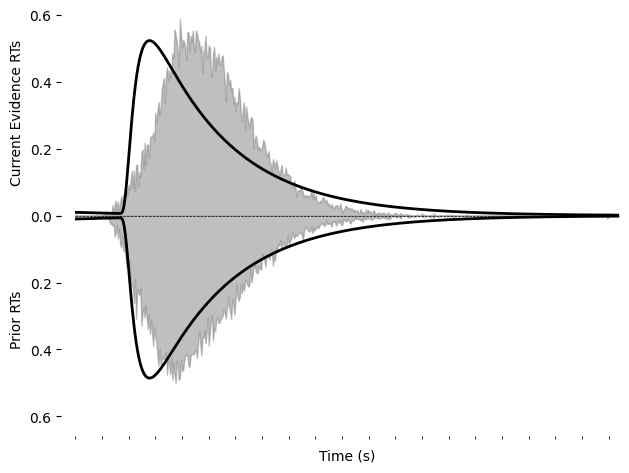

In [23]:
pyddm.plot.plot_fit_diagnostics(model=outliers_model, sample=data_sample)

Here we see that our DDM does not do a good job at predicting the RT distribution.

### Data cleaning

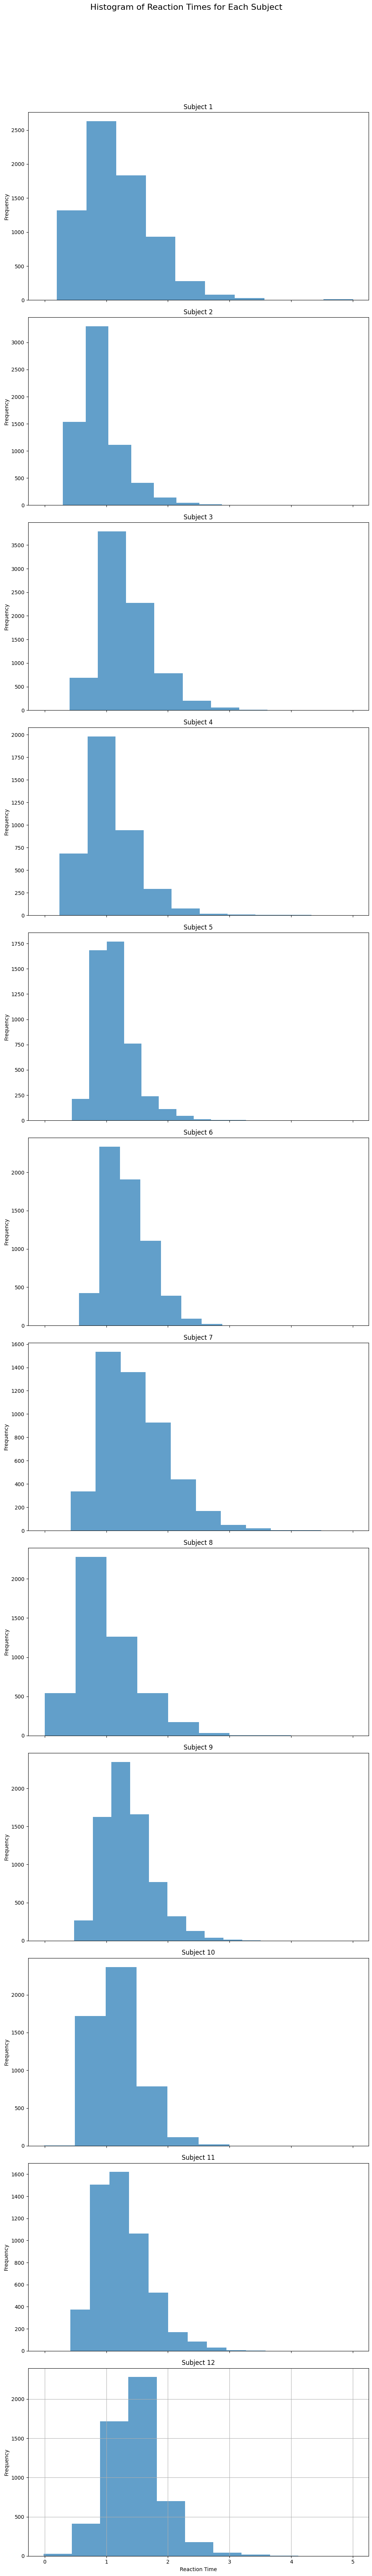

In [24]:
# @title Looking at RT distribution

data_rt["est_rt"].describe()

# Group the data by subject_id
temp = data_rt.groupby('subject_id')

# Get the number of subjects
num_subjects = len(temp)

# Create subplots
fig, axs = plt.subplots(num_subjects, 1, figsize=(10, 6 * num_subjects), sharex=True)

# Plot a histogram for each subject_id in separate panels
for i, (subject_id, group) in enumerate(temp):
    axs[i].hist(group['reaction_time'], bins=10, alpha=0.7)
    axs[i].set_title(f'Subject {subject_id}')
    axs[i].set_ylabel('Frequency')

plt.xlabel('Reaction Time')
plt.suptitle('Histogram of Reaction Times for Each Subject', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the spacing between subplots
plt.grid(True)
plt.show()


Looks like most of the subjects answer after 500ms. So excluding RT < 200ms should be sensible here.

In [25]:
percent_trials = np.round(len(data_rt[data_rt["est_rt"] < 0.2]) / len(data_rt)*100, 2)

print(f"Proportion of trials < 0.2s = {percent_trials} %")

Proportion of trials < 0.2s = 0.04 %


In [26]:
# @title Removing very short trials

# Remove short and long RTs, as in 10.1523/JNEUROSCI.4684-04.2005.
# This is not strictly necessary, but is performed here for
# compatibility with this study.
sub_df_rts = sub_df_rts[sub_df_rts["est_rt"] > .3] # Remove trials less than 100ms
sub_df_rts = sub_df_rts[sub_df_rts["est_rt"] < 5] # Remove trials greater than 5000ms

In [27]:
# @title Creating a list to store the models

model_list = []

### DDM simplest form - second fit

In [28]:
# @title Refitting the model to the curated data

# Create a sample object from our data.  This is the standard input
# format for fitting procedures.  Since RT and correct/error are
# both mandatory columns, their names are specified by command line
# arguments.
data_sample = Sample.from_pandas_dataframe(sub_df_rts, rt_column_name="reaction_time", choice_column_name="choice", choice_names=('Current Evidence', 'Prior'))

In [29]:
simplest_model = fit_adjust_model(sample=data_sample, model=simple_model, verbose=False, lossfunction=LossBIC)

Info: Params [0.20966646 0.96562609 0.39971043] gave 189628.77929281784
Info:pyddm:Params [0.20966646 0.96562609 0.39971043] gave 189628.77929281784


In [30]:
# @title Checking the fit
display_model(simplest_model)

Model simplest model with drift and boundaries information:
Choices: 'Current Evidence' (upper boundary), 'Prior' (lower boundary)
Drift component DriftCoherence:
    Drift depends linearly on coherence
    Fitted parameters:
    - driftdiff: 0.209666
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 0.965626
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.399710 (WARNING: AT BOUNDARY)
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: BIC
    Loss function value: 189628.77929281784
    Fitting method: 

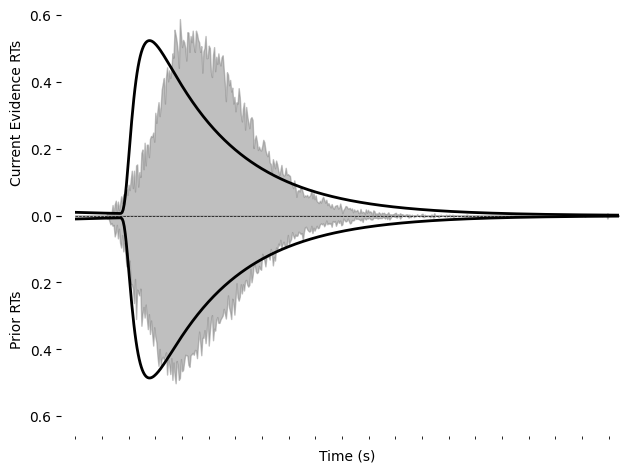

In [31]:
# @title Plotting the model
pyddm.plot.plot_fit_diagnostics(model=simplest_model, sample=data_sample)

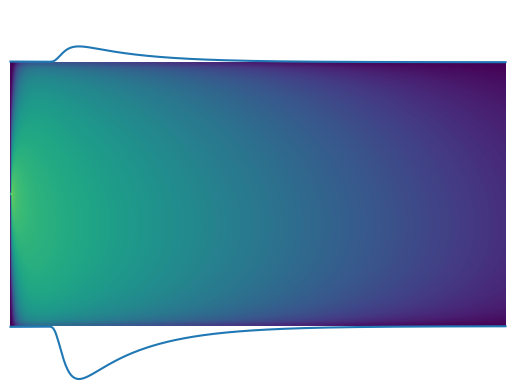

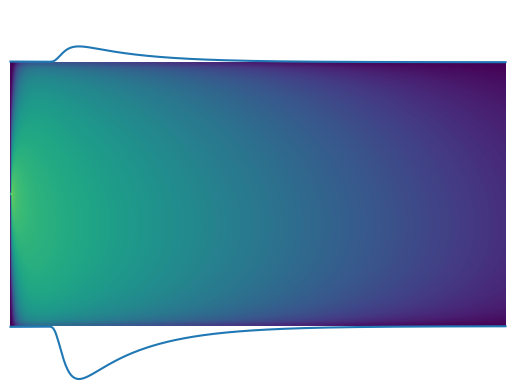

In [32]:
# @title Plot decision variable
pyddm.plot.plot_decision_variable_distribution(model=simplest_model, conditions = {'strength_diff': -3}, resolution=0.1, figure=None)

In [ ]:
#pyddm.plot.plot_decision_variable_distribution(model=simplest_model, conditions = {'strength_diff': 0}, resolution=0.1, figure=None)

In [ ]:
#pyddm.plot.plot_decision_variable_distribution(model=simplest_model, conditions = {'strength_diff': 3}, resolution=0.1, figure=None)

In [33]:
# @title GUI
pyddm.plot.model_gui_jupyter(model=simplest_model, sample=data_sample)

Output()

In [34]:
# @title Adding it to the model list

model_list.append(simplest_model)

### DDM with collapsing bounds

"Recently, the standard model has been challenged by alternative accounts that assume that less evidence is required to trigger a decision as time passes. Such “collapsing boundaries” or “urgency signals” have gained popularity in some theoretical accounts of neurophysiology."

#### Linearly collapsing bounds

In [35]:
# @title Creating model

# initialize the model
linear_collaps_bounds_model = Model(name='linear collapsing bounds',
                 drift=DriftCoherence(driftdiff=Fittable(minval=0, maxval=20)),
                 noise=NoiseConstant(noise=1),
                 bound=BoundCollapsingLinear(B = Fittable(minval=.1, maxval=1.5),
                                                    t=Fittable(minval=.0001, maxval=1.5)),
                 overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                                OverlayPoissonMixture(pmixturecoef=.02,
                                                                      rate=1)]),
                 dx=.01, dt=.01, T_dur=5.1, choice_names=('Current Evidence', 'Prior'))

In [36]:
# @title Fitting model
linear_collapsing_fit = fit_adjust_model(sample=data_sample, model=linear_collaps_bounds_model, verbose=False, lossfunction=LossBIC)

Info: Params [0.18667319 1.38937435 0.44170419 0.28404665] gave 175863.6203435477
Info:pyddm:Params [0.18667319 1.38937435 0.44170419 0.28404665] gave 175863.6203435477


In [37]:
# @title Checking the fit
display_model(linear_collapsing_fit)

Model linear collapsing bounds information:
Choices: 'Current Evidence' (upper boundary), 'Prior' (lower boundary)
Drift component DriftCoherence:
    Drift depends linearly on coherence
    Fitted parameters:
    - driftdiff: 0.186673 (WARNING: AT BOUNDARY)
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundCollapsingLinear:
    collapsing_linear
    Fitted parameters:
    - B: 1.389374
    - t: 0.441704
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.284047
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: BIC
    Loss function value: 175863.6203435477
  

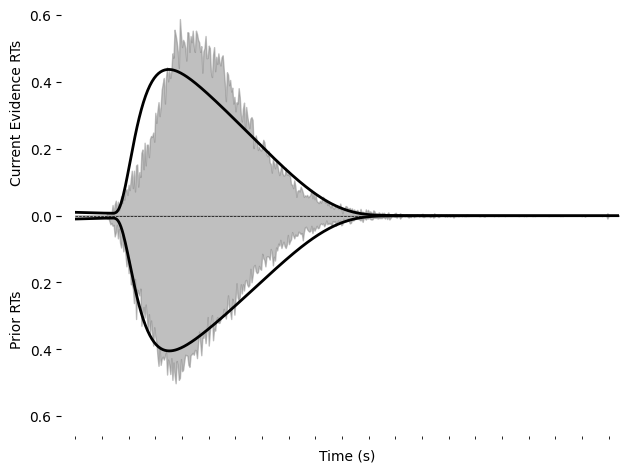

In [38]:
# @title Plotting the model
pyddm.plot.plot_fit_diagnostics(model=linear_collapsing_fit, sample=data_sample)

In [39]:
# @title Adding it to the model list
model_list.append(linear_collapsing_fit)

#### Exponential collapsing bounds

In [40]:
# @title Creating model

# initialize the model
exp_collaps_bounds_model = Model(name='exponential collapsing bounds',
                 drift=DriftCoherence(driftdiff=Fittable(minval=0, maxval=20)),
                 noise=NoiseConstant(noise=1),
                 bound=BoundCollapsingExponential(B=Fittable(minval=0.5, maxval=3),
                                                    tau=Fittable(minval=.0001, maxval=5)),
                 overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                                OverlayPoissonMixture(pmixturecoef=.02,
                                                                      rate=1)]),
                 dx=.01, dt=.01, T_dur=5.1, choice_names=('Current Evidence', 'Prior'))

In [41]:
# @title Fitting model
exp_collapsing_fit = fit_adjust_model(sample=data_sample, model=exp_collaps_bounds_model, verbose=False, lossfunction=LossBIC)

Info: Params [0.17026013 2.02140819 0.68789882 0.15868607] gave 174267.5669317247
Info:pyddm:Params [0.17026013 2.02140819 0.68789882 0.15868607] gave 174267.5669317247


In [42]:
# @title Checking the fit
display_model(exp_collapsing_fit)

Model exponential collapsing bounds information:
Choices: 'Current Evidence' (upper boundary), 'Prior' (lower boundary)
Drift component DriftCoherence:
    Drift depends linearly on coherence
    Fitted parameters:
    - driftdiff: 0.170260 (WARNING: AT BOUNDARY)
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundCollapsingExponential:
    collapsing_exponential
    Fitted parameters:
    - B: 2.021408
    - tau: 0.687899
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.158686
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: BIC
    Loss function value: 174

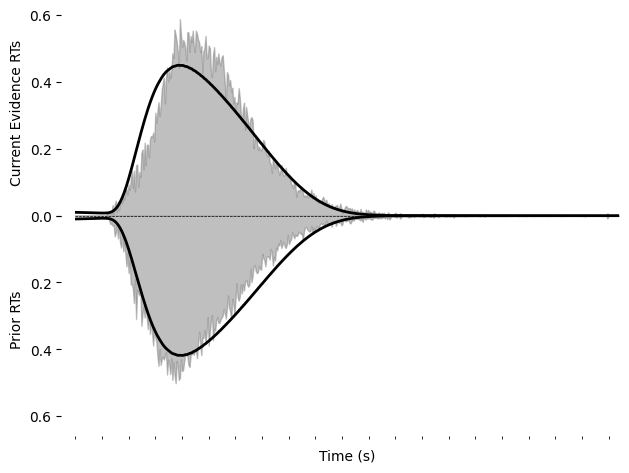

In [43]:
# @title Plotting the model
pyddm.plot.plot_fit_diagnostics(model=exp_collapsing_fit, sample=data_sample)

In [44]:
# @title Adding it to the model list
model_list.append(exp_collapsing_fit)

#### DDM with Weibull CDF collapsing bounds

In [45]:
# @title Creating model

# create the class
class BoundCollapsingWeibull(Bound):
    name = "Weibull CDF collapsing bounds"
    required_parameters = ["a", "aprime", "lam", "k"]
    def get_bound(self, t, **kwargs):
        l = self.lam
        a = self.a
        aprime = self.aprime
        k = self.k
        return a - (1 - np.exp(-(t/l)**k)) * (a - aprime)

# initialize the model
weibull_collaps_bounds_model = Model(name='weibull collapsing bounds',
                 drift=DriftCoherence(driftdiff=Fittable(minval=0, maxval=20)),
                 noise=NoiseConstant(noise=1),
                 bound=BoundCollapsingWeibull(a=Fittable(minval=1, maxval=2),
                                           aprime=Fittable(minval=0.001, maxval=1),
                                           lam=Fittable(minval=0.001, maxval=2),
                                           k=Fittable(minval=0.001, maxval=5)),
                 overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                                OverlayPoissonMixture(pmixturecoef=.02,
                                                                      rate=1)]),
                 dx=.01, dt=.01, T_dur=5.1, choice_names=('Current Evidence', 'Prior'))

In [46]:
# @title Fitting model

# takes some time to run
weibull_collapsing_fit = fit_adjust_model(sample=data_sample, model=weibull_collaps_bounds_model, verbose=False, lossfunction=LossBIC)

Info: Params [0.17791174 1.45999986 0.64738457 0.96489845 2.62347155 0.22939731] gave 172418.68760830627
Info:pyddm:Params [0.17791174 1.45999986 0.64738457 0.96489845 2.62347155 0.22939731] gave 172418.68760830627


In [47]:
# @title Checking the fit
display_model(weibull_collapsing_fit)

Model weibull collapsing bounds information:
Choices: 'Current Evidence' (upper boundary), 'Prior' (lower boundary)
Drift component DriftCoherence:
    Drift depends linearly on coherence
    Fitted parameters:
    - driftdiff: 0.177912 (WARNING: AT BOUNDARY)
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundCollapsingWeibull:
    Weibull CDF collapsing bounds
    Fitted parameters:
    - a: 1.460000
    - aprime: 0.647385
    - lam: 0.964898
    - k: 2.623472
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.229397
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss fu

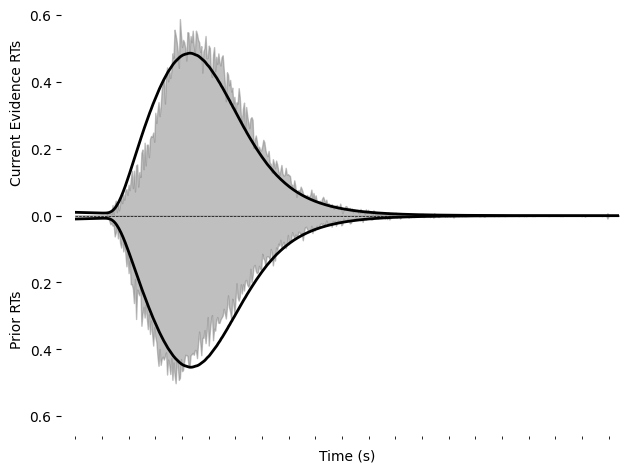

In [48]:
# @title Plotting the model
pyddm.plot.plot_fit_diagnostics(model=weibull_collapsing_fit, sample=data_sample)

In [49]:
# @title Adding it to the model list
model_list.append(weibull_collapsing_fit)

#### DDM with exponentially collapsing bounds after a delay

In [50]:
# @title Creating model

# create the class
class BoundCollapsingExponentialDelay(Bound):
    """Bound collapses exponentially over time.

    Takes three parameters:

    `B` - the bound at time t = 0.
    `tau` - the time constant for the collapse, should be greater than
    zero.
    `t1` - the time at which the collapse begins, in seconds
    """
    name = "Delayed exponential collapsing bound"
    required_parameters = ["B", "tau", "t1"]
    def get_bound(self, t, conditions, **kwargs):
        if t <= self.t1:
            return self.B
        if t > self.t1:
            return self.B * np.exp(-self.tau*(t-self.t1))

# initialize the model
exp_delay_collaps_bounds_model = Model(name='exp collapsing bound after delay',
                 drift=DriftCoherence(driftdiff=Fittable(minval=0, maxval=20)),
                 noise=NoiseConstant(noise=1),
                 bound=BoundCollapsingExponentialDelay(B=Fittable(minval=0.5, maxval=3),
                                                    tau=Fittable(minval=.0001, maxval=5),
                                                       t1=Fittable(minval=0.01, maxval = 4.9)),
                   overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                   OverlayPoissonMixture(pmixturecoef=.02, rate=1)]),
                 dx=.01, dt=.01, T_dur=5.1, choice_names=('Current Evidence', 'Prior'))

In [51]:
# @title Fitting model
exp_delay_collapsing_fit = fit_adjust_model(sample=data_sample, model=exp_delay_collaps_bounds_model, verbose=False, lossfunction=LossBIC)

Info: Params [0.21901397 1.3509336  0.62488788 0.39287445 0.25221475] gave 173782.8912876897
Info:pyddm:Params [0.21901397 1.3509336  0.62488788 0.39287445 0.25221475] gave 173782.8912876897


In [52]:
# @title Checking the fit
display_model(exp_delay_collapsing_fit)

Model exp collapsing bound after delay information:
Choices: 'Current Evidence' (upper boundary), 'Prior' (lower boundary)
Drift component DriftCoherence:
    Drift depends linearly on coherence
    Fitted parameters:
    - driftdiff: 0.219014
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundCollapsingExponentialDelay:
    Delayed exponential collapsing bound
    Fitted parameters:
    - B: 1.350934
    - tau: 0.624888
    - t1: 0.392874
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.252215
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: BIC
    Loss f

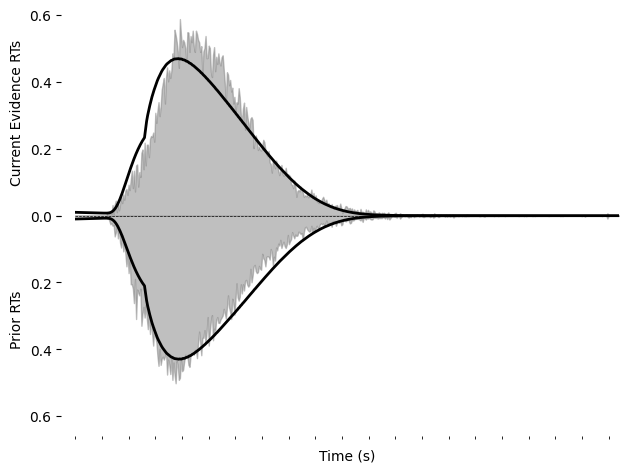

In [53]:
# @title Plotting the model
pyddm.plot.plot_fit_diagnostics(model=exp_delay_collapsing_fit, sample=data_sample)

In [54]:
# @title Adding it to the model list
model_list.append(exp_delay_collapsing_fit)

#### Urgency Gain Function fitting model

In [55]:
# @title Creating the model (not sure about this code in general)

# not sure about this code in general

# first define an urgency gain function to scale the drift and noise
def urgency_gain(t, gain_start, gain_slope):
    return gain_start + t*gain_slope


class DriftUrgencyGain(Drift):
    name = "strategy-dependent drift rate with an urgency gain function"
    required_parameters = ["snr", "gain_start", "gain_slope"]
    required_conditions = ["strength_diff"]

    # now we need to define the get_drift function
    def get_drift(self, t, conditions, **kwargs):

        # SNR times the gain
        cur_urgency = self.snr * urgency_gain(t, self.gain_start, self.gain_slope)

        return cur_urgency * conditions["strength_diff"]

# not sure yet if I need to change anything here
class NoiseUrgencyGain(Noise):
    name = "noise level with an urgency function"
    required_parameters = ["gain_start", "gain_slope"]

    def get_noise(self, t, **kwargs):
        return urgency_gain(t, self.gain_start, self.gain_slope)

# now let's create the model obejct
# from pyddm import Model, Fittable
# define gain_start and slope
gain_start = Fittable(minval=0, maxval=1)
gain_slope = Fittable(minval=0, maxval=2)

# and the model
urgency_gain_model = Model(name='urgency gain',
    drift=DriftUrgencyGain(snr=Fittable(minval=0, maxval=2),
                                                  gain_start=gain_start,
                                                  gain_slope=gain_slope),
                           noise=NoiseUrgencyGain(gain_start=gain_start,
                                                  gain_slope=gain_slope),
                           bound=BoundConstant(B=Fittable(minval=.1, maxval=1.5)),
                           overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                                          OverlayPoissonMixture(pmixturecoef=.02,
                                                                                rate=1)]),
                           dt=.01, dx=.01, T_dur=5.1)


In [56]:
# @title Fitting model

# fit the model
#fit_model_urgency = fit_adjust_model(sample=data_sample, model=urgency_gain_model, verbose=False)

In [57]:
# @title Checking the fit
#display_model(fit_model_urgency)

In [58]:
# @title Plotting the model
# plot diagnostics
#pyddm.plot.plot_fit_diagnostics(model=fit_model_urgency, sample=data_sample)

In [59]:
# @title Adding it to the model list
#model_list.append(fit_model_urgency)

### Intermediate conclusion - best urgency signal model

As we have different forms of urgency signals, we may want to look for the model that best fits our data.

In [60]:
index_winning, index_similar_list, _ = compare_models_list(model_list)
print(index_winning)
print(index_similar_list)
display_model(model_list[index_winning])

3
[]
Model weibull collapsing bounds information:
Choices: 'Current Evidence' (upper boundary), 'Prior' (lower boundary)
Drift component DriftCoherence:
    Drift depends linearly on coherence
    Fitted parameters:
    - driftdiff: 0.177912 (WARNING: AT BOUNDARY)
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundCollapsingWeibull:
    Weibull CDF collapsing bounds
    Fitted parameters:
    - a: 1.460000
    - aprime: 0.647385
    - lam: 0.964898
    - k: 2.623472
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.229397
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Lo

### Leaky DDM - constant bound

Second, drift rate and noise level may depend on position. This allows for model features such as unstable (Wong, 2006; Roxin and Ledberg, 2008; Erlich et al., 2015) and leaky (Wong, 2006; Ossmy et al., 2013; Farashahi et al., 2018) integration. Leaky integration with a short time constant is functionally similar to the urgency-gated model with a low pass filter (Hawkins et al., 2015a; Thura and Cisek, 2014).

Leaky = forget evidence over time.

https://scholar.google.com/scholar_lookup?author=O.+Ossmy&author=R.+Moran&author=T.+Pfeffer&author=K.+Tsetsos&author=M.+Usher&author=T.+H.+Donner&title=The+timescale+of+perceptual+evidence+integration+can+be+adapted+to+the+environment&publication_year=2013&journal=Current+Biology&volume=23&pages=981-986 *texte en italique*

In [63]:
# @title Creating model

# create conditions
conditions = ["strength_diff", "subject_id", "choice"]

data_sample = Sample.from_pandas_dataframe(sub_df_rts, rt_column_name="reaction_time", choice_column_name="choice", choice_names=('Current Evidence', 'Prior'))

# create leaky model class
class DriftCoherenceLeak(ddm.models.Drift):
    name = "Leaky drift depends linearly on choice strategy"
    required_parameters = ["driftdiff", "leak"] # <-- Parameters we want to include in the model
    required_conditions = ["strength_diff"] # <-- Task parameters ("conditions"). Should be the same name as in the sample.

    # We must always define the get_drift function, which is used to compute the instantaneous value of drift.
    def get_drift(self, x, conditions, **kwargs):
        return self.driftdiff * conditions['strength_diff'] + self.leak * x

# full model definition
model_leak = Model(name='Laquitaine data, leaky drift varies with strategy used',
                   drift=DriftCoherenceLeak(driftdiff=Fittable(minval=0, maxval=20),
                                            leak=Fittable(minval=-10, maxval=10)),
                   noise=NoiseConstant(noise=1),
                 bound=BoundConstant(B=Fittable(minval=.1, maxval=1.5)),
                   overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                                  OverlayPoissonMixture(pmixturecoef=.02,
                                                                        rate=1)]),
                   dx=.01, dt=.01, T_dur=5.1, choice_names=('Current Evidence', 'Prior'))


In [64]:
# @title Fitting model

# fit model
fit_model_leak = fit_adjust_model(sample=data_sample, model=model_leak, verbose=False, lossfunction=LossBIC)

Info: Params [0.20404728 1.72048995 1.45760157 0.36359299] gave 180227.55375030718
Info:pyddm:Params [0.20404728 1.72048995 1.45760157 0.36359299] gave 180227.55375030718


In [65]:
# @title Checking the fit

display_model(fit_model_leak)

Model Laquitaine data, leaky drift varies with strategy used information:
Choices: 'Current Evidence' (upper boundary), 'Prior' (lower boundary)
Drift component DriftCoherenceLeak:
    Leaky drift depends linearly on choice strategy
    Fitted parameters:
    - driftdiff: 0.204047
    - leak: 1.720490
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 1.457602
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.363593
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: BIC
    Loss function value: 180227.5537

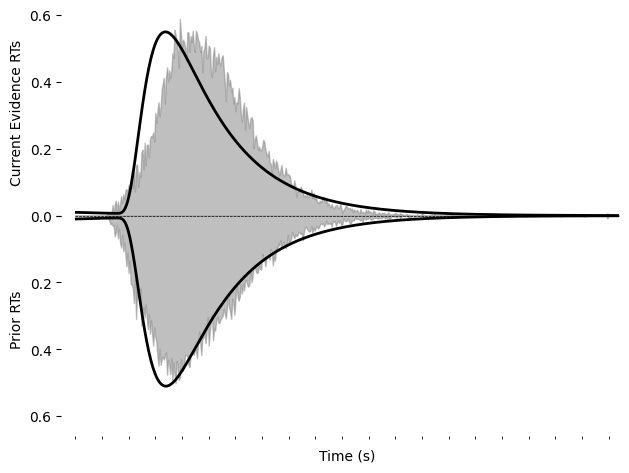

In [66]:
# @title Plotting the model

# plot diagnostics
pyddm.plot.plot_fit_diagnostics(model=fit_model_leak, sample=data_sample)

In [67]:
# plot on interactive window
pyddm.plot.model_gui_jupyter(model=model_leak, sample=data_sample)

Output()

**Notes on the drift-rate with leak:** very long to run. Using dx = .01 and dt = .01 speeds the fitting procedure a lot!

### Does the leak term improves the fit?

In [68]:
# @title Comparison with the simplest model
compare_models(simple_model, model_leak)

Loss function used: BIC. Model 1 value =  189628.77929281784 vs Model 2 value = 180227.55375030718.
Winning model = Model 2


We may also want to check whether it improves the fit once we have added the urgency signal. So we need to create a model with the leak term and the urgency signal that won the race, which is the Weibull.

In [71]:
# @title Creating model

# create conditions
conditions = ["strength_diff", "subject_id", "choice"]

data_sample = Sample.from_pandas_dataframe(sub_df_rts, rt_column_name="reaction_time", choice_column_name="choice", choice_names=('Current Evidence', 'Prior'))

# full model definition
model_leak_boundary = Model(name='Laquitaine data, leaky drift varies with strategy used',
                   drift=DriftCoherenceLeak(driftdiff=Fittable(minval=0, maxval=20),
                                            leak=Fittable(minval=-10, maxval=10)),
                   noise=NoiseConstant(noise=1),
bound=BoundCollapsingWeibull(a=Fittable(minval=1, maxval=2),
                                           aprime=Fittable(minval=0.001, maxval=1),
                                           lam=Fittable(minval=0.001, maxval=2),
                                           k=Fittable(minval=0.001, maxval=5)),
                   overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                                  OverlayPoissonMixture(pmixturecoef=.02,
                                                                        rate=1)]),
                   dx=.01, dt=.01, T_dur=5.1, choice_names=('Current Evidence', 'Prior'))

In [72]:
# @title Fitting the model

# fit model
fit_model_leak_boundary = fit_adjust_model(sample=data_sample, model=model_leak_boundary, verbose=False, lossfunction=LossBIC)

Info: Params [0.17209111 0.22191044 1.60995606 0.65738723 0.9971655  2.4059048
 0.2053774 ] gave 172541.37937314704
Info:pyddm:Params [0.17209111 0.22191044 1.60995606 0.65738723 0.9971655  2.4059048
 0.2053774 ] gave 172541.37937314704


In [73]:
# @title Checking the fit

display_model(fit_model_leak_boundary)

Model Laquitaine data, leaky drift varies with strategy used information:
Choices: 'Current Evidence' (upper boundary), 'Prior' (lower boundary)
Drift component DriftCoherenceLeak:
    Leaky drift depends linearly on choice strategy
    Fitted parameters:
    - driftdiff: 0.172091 (WARNING: AT BOUNDARY)
    - leak: 0.221910
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundCollapsingWeibull:
    Weibull CDF collapsing bounds
    Fitted parameters:
    - a: 1.609956
    - aprime: 0.657387
    - lam: 0.997166
    - k: 2.405905
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.205377
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixtureco

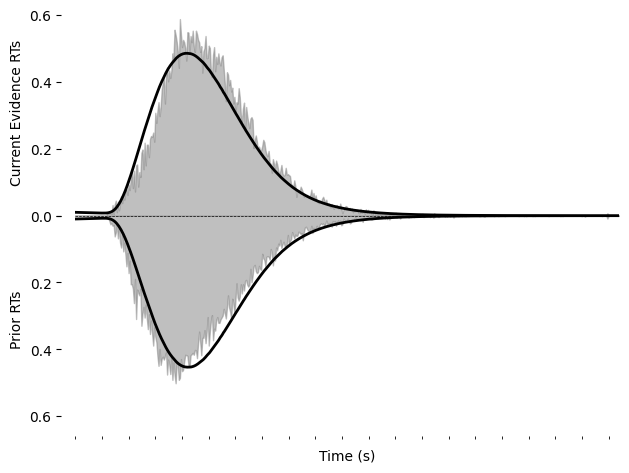

In [74]:
# @title Plotting the model

pyddm.plot.plot_fit_diagnostics(model=fit_model_leak_boundary, sample=data_sample)

In [75]:
# @title Comparing it to the constant bound model

compare_models(weibull_collapsing_fit, fit_model_leak_boundary)

Loss function used: BIC. Model 1 value =  172418.68760830627 vs Model 2 value = 172541.37937314704.
Winning model = Model 1


### Conclusion at the group level model

Winning model = Weibull collapsing boundaries without a leak term.

### RANDOM EFFECTS - SUBJECT - BY - SUBJECT MODEL COMPARISON


In [ ]:
# how many subjects?
subjects = data_rt.subject_id.unique() # [ 1 2 3 4 5 ...]

# list which contains every fitted model for each subject
subjects_models_list = []

# init empty lists:
winmodel = [] # every subject's winning model will be added here
allBIC = [] # every subject's winning model's BIC values will be added here

In [ ]:
for sub in subjects:

  this_sub = sub

  print(f"Subject number = {this_sub}.")
  print(" \ ")

  # extract data for subject  sub
  sub_df_rts = data_rt[data_rt["subject_id"] == this_sub]

  # Remove short and long RTs, as in 10.1523/JNEUROSCI.4684-04.2005.
  # This is not strictly necessary, but is performed here for
  # compatibility with this study.
  sub_df_rts = sub_df_rts[sub_df_rts["est_rt"] > .3] # Remove trials less than 100ms
  sub_df_rts = sub_df_rts[sub_df_rts["est_rt"] < 5] # Remove trials greater than 5000ms

  # create empty list for models to be compared:
  model_listRE = []

  # now start running models and appending to model_list

  # Create a sample object from our data.
  data_sample = Sample.from_pandas_dataframe(sub_df_rts, rt_column_name="reaction_time", choice_column_name="choice", choice_names=('Current Evidence', 'Prior'))

  # create conditions
  conditions = ["strength_diff", "subject_id", "choice"]

  # FIT MODEL
  simplest_model = fit_adjust_model(sample=data_sample, model=simple_model, verbose=False, lossfunction=LossBIC)

  # append model to list
  model_listRE.append(simplest_model)

  # @title Fitting model
  linear_collapsing_fit = fit_adjust_model(sample=data_sample, model=linear_collaps_bounds_model, verbose=False, lossfunction=LossBIC)

  # @title Adding it to the model list
  model_listRE.append(linear_collapsing_fit)

  # @title Fitting model
  exp_collapsing_fit = fit_adjust_model(sample=data_sample, model=exp_collaps_bounds_model, verbose=False, lossfunction=LossBIC)

  # @title Adding it to the model list
  model_listRE.append(exp_collapsing_fit)

  # weibull
  weibull_collapsing_fit = fit_adjust_model(sample=data_sample, model=weibull_collaps_bounds_model, verbose=False, lossfunction=LossBIC)
  model_listRE.append(weibull_collapsing_fit)

  # exp delay
  exp_delay_collapsing_fit = fit_adjust_model(sample=data_sample, model=exp_delay_collaps_bounds_model, verbose=False, lossfunction=LossBIC)
  model_listRE.append(exp_delay_collapsing_fit)

  # leak constant boundary
  fit_model_leak = fit_adjust_model(sample=data_sample, model=model_leak, verbose=False, lossfunction=LossBIC)
  model_listRE.append(fit_model_leak)

  # add it to the models list for each subject
  subjects_models_list.append(model_listRE)

 # compare models
  a,b,c = compare_models_list(model_listRE)

  # append results for each subject
  winmodel.append(a) # append model index
  allBIC.append(c) # append BIC values

In [ ]:
print(winmodel)

### Plot winning model per participant on a histogram


In [ ]:
winmodel = [4, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3]


# Convert list to pd.DataFrame
winmodel_df = pd.DataFrame(winmodel, columns=['model_number'])

# Count the occurrences of each model_number
model_counts = winmodel_df['model_number'].value_counts()

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(5, 6))

# Define colors for each model (you can add more colors if needed)
colors = ['red', 'green', 'blue', 'orange', 'purple']

# Plot the stacked bar with different colored rectangles
bottom = 0
bar_width = 0.01  # Set the width of the bars here (smaller value makes the bars narrower)

for i, (model_num, count) in enumerate(model_counts.items()):
    ax.bar(0, count, color=colors[i], bottom=bottom, label=f'{"Weibull CDF collapsing bounds" if model_num == 3 else "Exponential collapsing bounds with delay" if model_num == 4 else "Exponential collapsing bounds"}', width=0.4)  # Adjust width here
    bottom += count
# Set labels and legend
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.legend(loc='upper right')  # Move the legend to the upper right corner

# Remove ticks and digits on the x-axis
ax.set_xticks([])
ax.set_xticklabels([])

# Set the title for the plot and the legend
ax.set_title('Distribution of Best-Fitting Models Among Participants')
ax.legend(title='Models')
# Increase the space between the bars and the vertical edges of the plot

ax.set_xlim(-0.5, 0.5)

# Show the plot
plt.tight_layout()
plt.show()

### DDM with a bias as a function of choice history

In [76]:
data_sample = Sample.from_pandas_dataframe(sub_df_rts, rt_column_name="reaction_time", choice_column_name="choice", choice_names=('Current Evidence', 'Prior'))

# create conditions
conditions = ["strength_diff", "choice_hist", "subject_id", "choice"]

# Create the drift class
class DriftChoiceHist(ddm.models.Drift):
    name = "Drift depends linearly on coherence with a choice history bias."
    required_parameters = ["driftdiff", "choice_bias"] # <-- Parameters we want to include in the model
    required_conditions = ["strength_diff", "choice_hist"] # <-- Task parameters ("conditions").
    #Should be the same name as in the sample.

    # We must always define the get_drift function, which is used to compute the instantaneous value of drift.
    def get_drift(self, conditions, **kwargs):
        choice_bias = self.choice_bias * (1 if conditions['choice_hist'] == 1 else -1)
        return self.driftdiff * conditions['strength_diff'] + choice_bias

# create the  Bounds class
class BoundCollapsingWeibull(Bound):
    name = "Weibull CDF collapsing bounds"
    required_parameters = ["a", "aprime", "lam", "k"]

    def get_bound(self, t, **kwargs):
        l = self.lam
        a = self.a
        aprime = self.aprime
        k = self.k
        return a - (1 - np.exp(-(t/l)**k)) * (a - aprime)


# initialize the model
weibull_collaps_bounds_history_model = Model(name='Laquitaine data, drift varies with choice history',
                 drift=DriftChoiceHist(driftdiff=Fittable(minval=0, maxval=20),
                 choice_bias=Fittable(minval=0, maxval=1)),
                 noise=NoiseConstant(noise=1),
                 bound=BoundCollapsingWeibull(a=Fittable(minval=1, maxval=2),
                                           aprime=Fittable(minval=0.001, maxval=1),
                                           lam=Fittable(minval=0.001, maxval=2),
                                           k=Fittable(minval=0.001, maxval=5)),
                 overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                                OverlayPoissonMixture(pmixturecoef=.02,
                                                                      rate=1)]),
                 dx=.01, dt=.01, T_dur=5.1, choice_names=('Current Evidence', 'Prior'))

# takes some time to run
weibull__history_fit = fit_adjust_model(sample=data_sample, model=weibull_collaps_bounds_history_model, verbose=False, lossfunction=LossBIC)



Info: Params [0.17412712 0.06473713 1.28000001 0.62337023 1.01203988 2.8106771
 0.2728611 ] gave 172499.36298213832
Info:pyddm:Params [0.17412712 0.06473713 1.28000001 0.62337023 1.01203988 2.8106771
 0.2728611 ] gave 172499.36298213832


In [77]:
# print the full fitted model
display_model(weibull__history_fit)

Model Laquitaine data, drift varies with choice history information:
Choices: 'Current Evidence' (upper boundary), 'Prior' (lower boundary)
Drift component DriftChoiceHist:
    Drift depends linearly on coherence with a choice history bias.
    Fitted parameters:
    - driftdiff: 0.174127 (WARNING: AT BOUNDARY)
    - choice_bias: 0.064737
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundCollapsingWeibull:
    Weibull CDF collapsing bounds
    Fitted parameters:
    - a: 1.280000
    - aprime: 0.623370
    - lam: 1.012040
    - k: 2.810677
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.272861
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
     

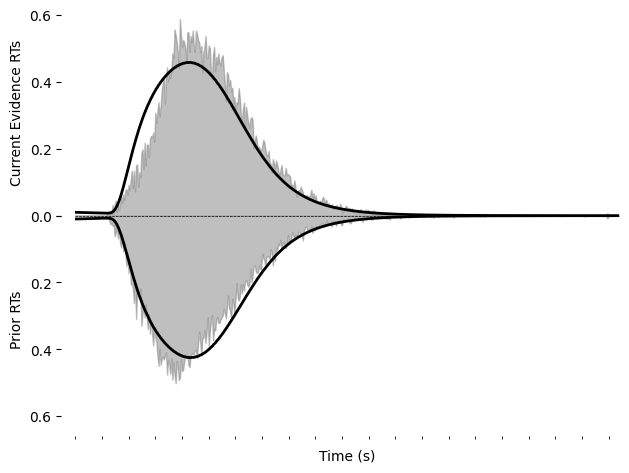

In [78]:
# plot the results
pyddm.plot.plot_fit_diagnostics(model=weibull__history_fit, sample=data_sample)

In [79]:
# @title Comparing the fits of the weibull model with and without the bias
compare_models(weibull_collapsing_fit, weibull__history_fit )

Loss function used: BIC. Model 1 value =  172418.68760830627 vs Model 2 value = 172499.36298213832.
Winning model = Model 1


### **Bias model 2**: Choice history only for drift_diff == 0

In [80]:
# extract data for strength_diff == 0
subset_rts = data_rt[data_rt["strength_diff"]==0]

data_sample = Sample.from_pandas_dataframe(subset_rts, rt_column_name="reaction_time", choice_column_name="choice", choice_names=('Current Evidence', 'Prior'))

# fit subset (drift_diff == 0) model
weibull__history_subset_fit = fit_adjust_model(sample=data_sample, model=weibull_collaps_bounds_history_model, verbose=False, lossfunction=LossBIC)


Info: Params [1.22802363 0.06311995 1.55999993 0.65613139 0.93711002 2.29227447
 0.20693385] gave 75517.65577468189
Info:pyddm:Params [1.22802363 0.06311995 1.55999993 0.65613139 0.93711002 2.29227447
 0.20693385] gave 75517.65577468189


In [81]:
# print the full fitted model
display_model(weibull__history_fit)

Model Laquitaine data, drift varies with choice history information:
Choices: 'Current Evidence' (upper boundary), 'Prior' (lower boundary)
Drift component DriftChoiceHist:
    Drift depends linearly on coherence with a choice history bias.
    Fitted parameters:
    - driftdiff: 1.228024
    - choice_bias: 0.063120
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundCollapsingWeibull:
    Weibull CDF collapsing bounds
    Fitted parameters:
    - a: 1.560000
    - aprime: 0.656131
    - lam: 0.937110
    - k: 2.292274
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.206934
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.02

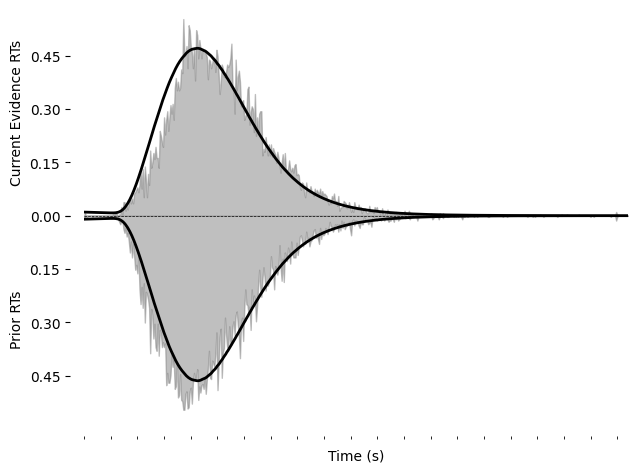

In [82]:
# plot the results
pyddm.plot.plot_fit_diagnostics(model=weibull__history_fit, sample=data_sample)